# Autoencoder Training (FPN-8)

In this notebook, we’re building and training an Autoencoder model that learns 
what *normal* transactions look like. The idea is simple:

- Train only on legitimate (Class = 0) transactions  
- The Autoencoder learns to reconstruct them well  
- Fraud transactions should reconstruct poorly (high error)  
- This reconstruction error becomes our anomaly score  

We'll follow these steps:

1. Load the preprocessed train/val/test data  
2. Keep only legit samples for training  
3. Build a small neural Autoencoder  
4. Train with early stopping  
5. Calculate reconstruction errors  
6. Pick a threshold from validation data  
7. Evaluate on the test set  
8. Plot losses + error distributions  

Let's get started.


In [4]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    recall_score,
    precision_score,
    confusion_matrix,
)

from tensorflow.keras import layers, models, callbacks

from pathlib import Path

# Notebook-safe root resolution
ROOT = Path.cwd().parents[0]

DATA_DIR = ROOT / "data" / "processed"
ARTIFACT_DIR = ROOT / "artifacts"
PLOT_DIR = ARTIFACT_DIR / "plots"

ARTIFACT_DIR.mkdir(exist_ok=True)
PLOT_DIR.mkdir(exist_ok=True)

TRAIN_PATH = DATA_DIR / "train.csv"
VAL_PATH = DATA_DIR / "val.csv"
TEST_PATH = DATA_DIR / "test.csv"

TRAIN_PATH, VAL_PATH, TEST_PATH



(PosixPath('/Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/data/processed/train.csv'),
 PosixPath('/Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/data/processed/val.csv'),
 PosixPath('/Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection/data/processed/test.csv'))

In [5]:
print(ROOT)
print(TRAIN_PATH.exists(), VAL_PATH.exists(), TEST_PATH.exists())


/Users/lavanyasrinivas/Documents/AI-First-Preauth-Fraud-Detection/AI-First-Preauth-Fraud-Detection
True True True


### Loading the processed datasets

These CSVs already went through:
- enrichment  
- scaling  
- encoding  
- time-based splitting  

So at this point, they are clean and ready for modeling.

We'll load them with pandas and break them into X/y.


In [6]:
train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

X_train = train_df.drop(columns=["Class"])
y_train = train_df["Class"]

X_val = val_df.drop(columns=["Class"])
y_val = val_df["Class"]

X_test = test_df.drop(columns=["Class"])
y_test = test_df["Class"]

print(train_df.shape, val_df.shape, test_df.shape)
train_df.head()


(27942, 7622) (3000, 7622) (3000, 7622)


,num__V1,num__V2,num__V3,num__V4,num__V5,num__V6,num__V7,num__V8,num__V9,num__V10,...,cat__shipping_country_NL,cat__shipping_country_PL,cat__shipping_country_PT,cat__shipping_country_SE,cat__shipping_country_US,cat__night_txn_False,cat__night_txn_True,cat__weekend_txn_False,cat__weekend_txn_True,Class
0,-0.649517,-0.048913,1.494531,0.922473,-0.158176,0.330668,0.249599,0.058638,0.317264,0.084467,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
1,-1.397055,-0.207361,0.892485,1.199721,-0.009437,0.598080,-0.292304,-1.682651,0.658507,1.026648,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
2,-0.955788,-0.031588,-0.485320,-0.780396,2.260404,2.261578,0.002035,0.715677,0.044026,0.513617,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
3,0.672772,0.215974,-0.021317,0.748291,-0.035972,-0.737123,0.355464,-0.311146,-0.214234,-0.037212,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
4,-0.988333,1.362461,-0.115308,0.766713,-0.509763,0.113693,-0.451149,1.301896,-0.510424,0.119195,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0


### Filter legitimate samples for training

The Autoencoder should only learn *normal* (non-fraud) behavior.  
So we extract Class = 0 transactions from both:

- training (for fitting the AE)
- validation (for finding the threshold later)

This aligns with the idea:  
> “Learn normal → detect deviations”


In [15]:
# Filter only legitimate (non-fraud) samples for training / thresholding
legit_train_mask = y_train == 0
legit_val_mask = y_val == 0

X_train_legit = X_train[legit_train_mask].values
X_val_legit = X_val[legit_val_mask].values

print("Class distribution (train):")
print(y_train.value_counts(normalize=True))

print("\nShapes after filtering legit:")
print("  X_train_legit:", X_train_legit.shape)
print("  X_val_legit:  ", X_val_legit.shape)


Class distribution (train):
Class
0    0.5
1    0.5
Name: proportion, dtype: float64

Shapes after filtering legit:
  X_train_legit: (13971, 7621)
  X_val_legit:   (2995, 7621)


In [7]:
legit_train_mask = y_train == 0
legit_val_mask = y_val == 0

X_train_legit = X_train[legit_train_mask].values
X_val_legit = X_val[legit_val_mask].values

X_train_legit.shape, X_val_legit.shape


((13971, 7621), (2995, 7621))

### Build the Autoencoder model

This is a simple dense neural network with a bottleneck in the middle.
It compresses the input → learns structure → reconstructs it.

If the reconstruction is bad (high error), the transaction is suspicious.


In [8]:
def build_autoencoder(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(input_dim, activation='linear'),
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

input_dim = X_train_legit.shape[1]
autoencoder = build_autoencoder(input_dim)

autoencoder.summary()


2025-11-14 17:30:02.051441: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-11-14 17:30:02.051497: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-11-14 17:30:02.051503: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-11-14 17:30:02.051543: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-14 17:30:02.051561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       487,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7621)           │       495,365 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 988,437 (3.77 MB)

 Trainable params: 988,437 (3.77 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Autoencoder

We're using:
- 100 epochs  
- Early stopping (stop if val loss doesn’t improve for 5 rounds)  
- Batch size 512  

Lots of features → batch size helps stabilize training.


In [9]:
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

history = autoencoder.fit(
    X_train_legit,
    X_train_legit,
    validation_data=(X_val_legit, X_val_legit),
    epochs=100,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1,
)


Epoch 1/100


2025-11-14 17:32:10.187973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0050 - val_loss: 0.0056
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

### Visualize training vs validation loss

A clean, steady decline means the model is learning normal patterns.
If val_loss starts rising → that’s where early stopping kicks in.


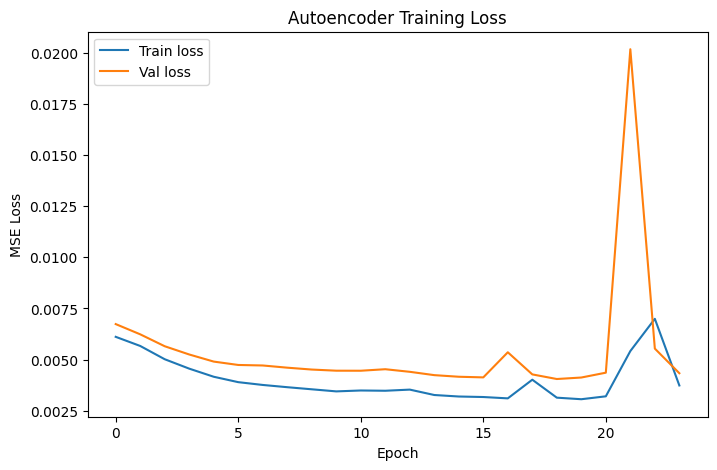

In [10]:
train_loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train loss")
plt.plot(val_loss, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Training Loss")
plt.legend()
plt.show()


### Helper to compute reconstruction errors

We’ll apply this function to:
- legit validation data → choose threshold  
- full test data → evaluate performance


In [21]:
def reconstruction_errors(model, X):
    """
    Compute reconstruction errors (MSE per row) for an autoencoder.
    """
    X = np.asarray(X)
    X_pred = model.predict(X, verbose=0)

    if X.shape != X_pred.shape:
        raise ValueError(f"Shape mismatch: X={X.shape}, X_pred={X_pred.shape}")

    return np.mean((X - X_pred) ** 2, axis=1)


In [23]:
# Reconstruction errors on legit validation and full test set
val_legit_errors = reconstruction_errors(autoencoder, X_val_legit)
test_errors = reconstruction_errors(autoencoder, X_test.values)

print("Val legit errors:")
print("  mean:", float(val_legit_errors.mean()))
print("  std: ", float(val_legit_errors.std()))
print("Test errors:")
print("  mean:", float(test_errors.mean()))
print("  std: ", float(test_errors.std()))


Val legit errors:
  mean: 0.00404589630855279
  std:  0.015726255261303657
Test errors:
  mean: 0.0033159787840134174
  std:  0.00520021630956083


In [24]:
# -------------------------------
# 1. Determine threshold (95th percentile of legit val errors)
# -------------------------------
threshold = np.percentile(val_legit_errors, 95)
print("Chosen threshold (95th percentile):", threshold)

# -------------------------------
# 2. Classify test samples
# -------------------------------
test_pred = (test_errors > threshold).astype(int)

# y_test is the true labels (0/1) already loaded
y_test_array = y_test.values

# -------------------------------
# 3. Compute metrics
# -------------------------------
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix
)

precision = precision_score(y_test_array, test_pred, zero_division=0)
recall = recall_score(y_test_array, test_pred, zero_division=0)
f1 = f1_score(y_test_array, test_pred, zero_division=0)

# For ROC-AUC, use raw errors
roc_auc = roc_auc_score(y_test_array, test_errors)
pr_auc = average_precision_score(y_test_array, test_errors)

cm = confusion_matrix(y_test_array, test_pred)

print("\n📊 Autoencoder Performance on Test Set")
print("--------------------------------------")
print("Threshold:", threshold)
print("Precision:", precision)
print("Recall (TPR):", recall)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)
print("\nConfusion Matrix:\n", cm)


Chosen threshold (95th percentile): 0.005953793065511987

📊 Autoencoder Performance on Test Set
--------------------------------------
Threshold: 0.005953793065511987
Precision: 0.015625
Recall (TPR): 1.0
F1-score: 0.03076923076923077
ROC-AUC: 0.9854903268845897
PR-AUC: 0.03260328521652563

Confusion Matrix:
 [[2872  126]
 [   0    2]]


In [26]:
print("Autoencoder Evaluation Metrics\n")

print(f"Precision:            {precision}")
print(f"Recall (TPR):         {recall}")
print(f"False Positive Rate:  {fpr}")
print(f"ROC-AUC:              {roc_auc}")
print(f"PR-AUC:               {pr_auc}")

print("\nConfusion Matrix:")
print(cm)


Autoencoder Evaluation Metrics

Precision:            0.015625
Recall (TPR):         1.0
False Positive Rate:  0.042028018679119414
ROC-AUC:              0.9854903268845897
PR-AUC:               0.03260328521652563

Confusion Matrix:
[[2872  126]
 [   0    2]]


### Pick detection threshold from validation set

We take the **95th percentile** of reconstruction errors on legit samples.

Meaning:
> Only 5% of *normal* transactions should exceed this threshold.


### Evaluate on the test set

Now we treat:
- high reconstruction error = suspicious = fraud  
- low reconstruction error = normal  

We compute:
- Precision  
- Recall (TPR)  
- FPR  
- F1  
- ROC-AUC  
- PR-AUC  
- Confusion matrix  


In [13]:
test_errors = reconstruction_errors(autoencoder, X_test.values)

y_scores = test_errors
y_pred = (test_errors >= threshold).astype(int)

precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)
cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)

precision, recall, fpr, roc_auc, pr_auc, cm


(0.015625,
 1.0,
 0.042028018679119414,
 0.9854903268845897,
 0.03260328521652563,
 array([[2872,  126],
        [   0,    2]]))

### Compare legit vs fraud error distributions

Ideally:
- Legit errors cluster on the left  
- Fraud errors cluster on the right  
- Threshold sits somewhere between  

This plot helps visualize separation.


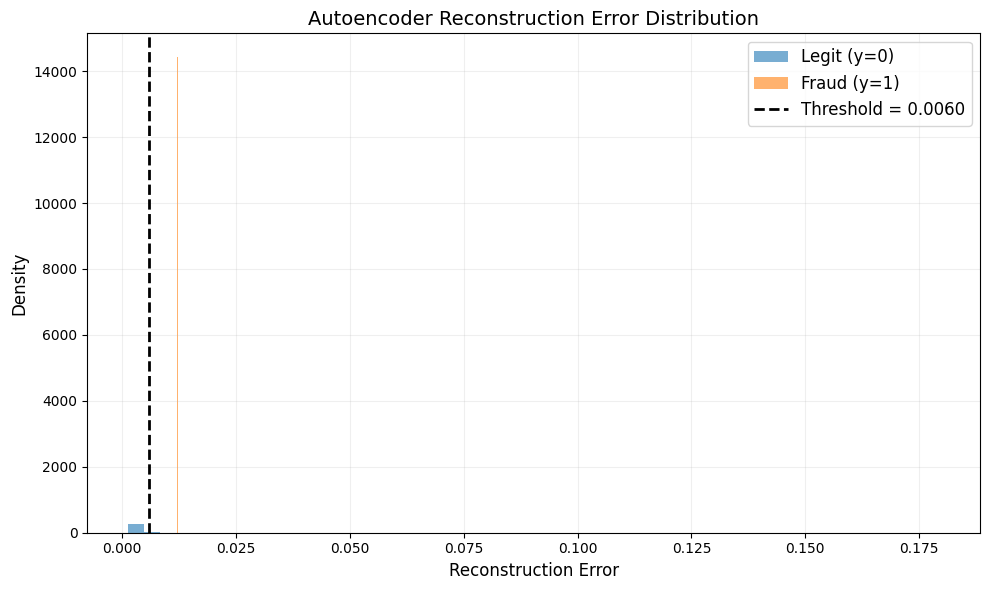

In [25]:
# Reconstruction error distributions for legit vs fraud
errors_legit = test_errors[y_test == 0]
errors_fraud = test_errors[y_test == 1]

plt.figure(figsize=(10,6))

plt.hist(errors_legit, bins=50, alpha=0.6, density=True, label="Legit (y=0)")
plt.hist(errors_fraud, bins=50, alpha=0.6, density=True, label="Fraud (y=1)")

plt.axvline(threshold, color='black', linestyle='--', linewidth=2,
            label=f"Threshold = {threshold:.4f}")

plt.title("Autoencoder Reconstruction Error Distribution", fontsize=14)
plt.xlabel("Reconstruction Error", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=12)

plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [29]:
# Get indices of fraud samples
fraud_indices = np.where(y_test.values == 1)[0]

# Pick the fraud sample with the highest reconstruction error
fraud_idx = fraud_indices[np.argmax(test_errors[fraud_indices])]
fraud_idx


1377

In [30]:
# Extract original and reconstructed vectors
sample = X_test.values[fraud_idx]
sample_recon = autoencoder.predict(sample.reshape(1, -1), verbose=0)[0]

# Compute feature-wise squared error
feature_errors = (sample - sample_recon) ** 2


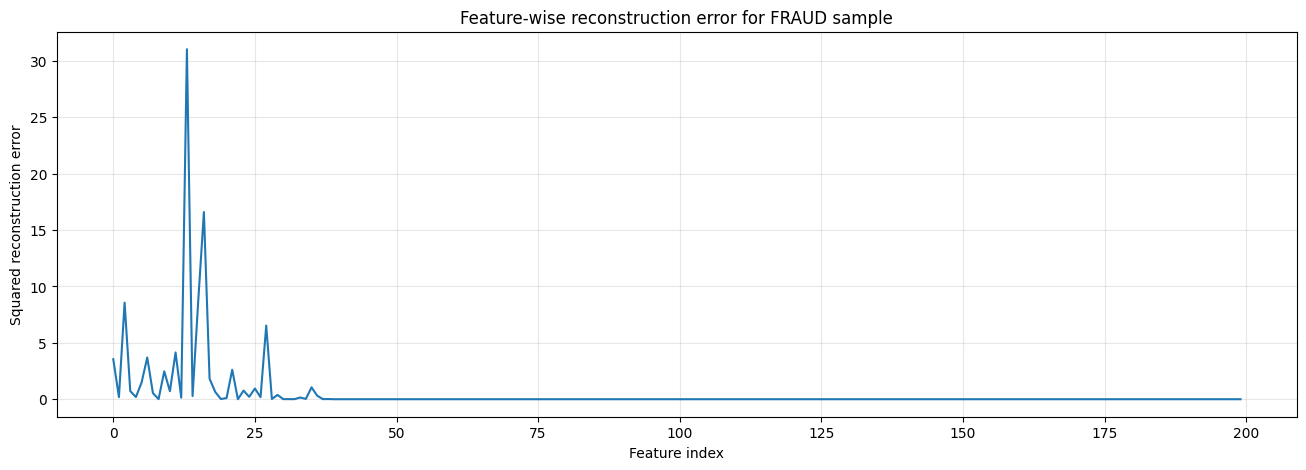

In [31]:
plt.figure(figsize=(16,5))
plt.plot(feature_errors[:200])  # show first 200 features so plot is readable
plt.title("Feature-wise reconstruction error for FRAUD sample")
plt.xlabel("Feature index")
plt.ylabel("Squared reconstruction error")
plt.grid(alpha=0.3)
plt.show()


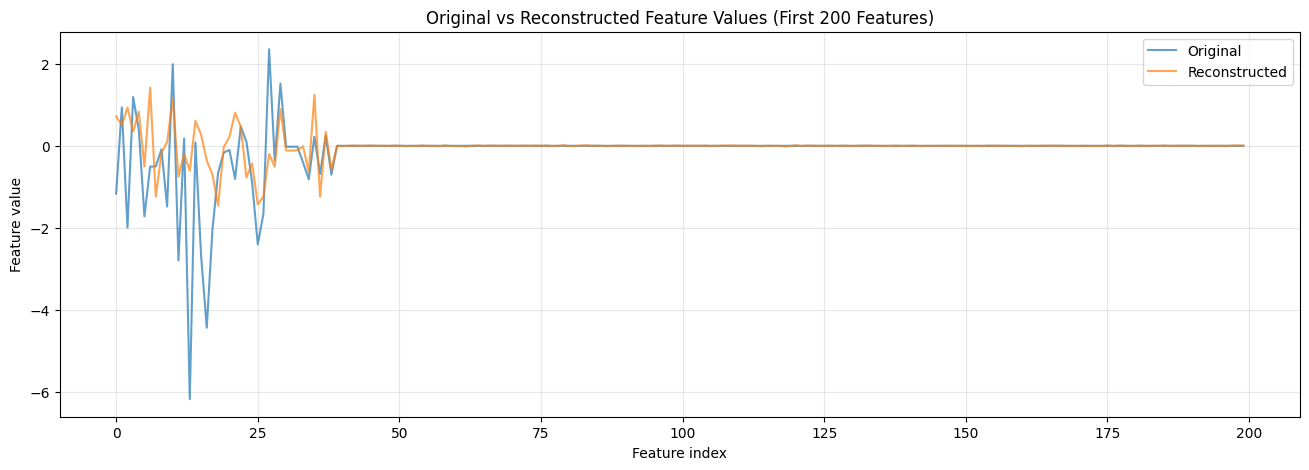

In [32]:
plt.figure(figsize=(16,5))
plt.plot(sample[:200], label="Original", alpha=0.7)
plt.plot(sample_recon[:200], label="Reconstructed", alpha=0.7)
plt.title("Original vs Reconstructed Feature Values (First 200 Features)")
plt.xlabel("Feature index")
plt.ylabel("Feature value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [33]:
top_features = np.argsort(feature_errors)[-10:]

print("Top anomalous feature indices (highest error):", top_features)
print("Top feature errors:", feature_errors[top_features])


Top anomalous feature indices (highest error): [ 9 21  0  6 11 27  2 15 16 13]
Top feature errors: [ 2.47439145  2.6124003   3.55106377  3.70012831  4.14710662  6.52843794
  8.56723876  8.71880878 16.59584424 31.03364698]


In [34]:
import numpy as np
import pandas as pd

# 1. Get indices of fraud samples in the test set
fraud_indices = np.where(y_test.values == 1)[0]
print("Fraud indices in test set:", fraud_indices)

# 2. Among frauds, pick the one with the highest reconstruction error
fraud_idx = fraud_indices[np.argmax(test_errors[fraud_indices])]
print("Using fraud index:", fraud_idx)

# 3. Extract original + reconstructed vectors for that sample
sample = X_test.values[fraud_idx]
sample_recon = autoencoder.predict(sample.reshape(1, -1), verbose=0)[0]

# 4. Compute per-feature squared error
feature_errors = (sample - sample_recon) ** 2

# 5. Attach feature names
feature_names = X_test.columns

error_df = pd.DataFrame({
    "feature": feature_names,
    "original": sample,
    "reconstructed": sample_recon,
    "squared_error": feature_errors
})

# Sort by highest error
error_df_sorted = error_df.sort_values("squared_error", ascending=False)

error_df_sorted.head(10)


Fraud indices in test set: [1377 2665]
Using fraud index: 1377


,feature,original,reconstructed,squared_error
13,num__V14,-6.179539,-0.608753,31.033647
16,num__V17,-4.436342,-0.362542,16.595844
15,num__V16,-2.681958,0.270805,8.718809
2,num__V3,-1.994092,0.932892,8.567239
27,num__V28,2.355168,-0.199913,6.528438
11,num__V12,-2.795060,-0.758616,4.147107
6,num__V7,-0.508264,1.415308,3.700128
0,num__V1,-1.166059,0.718367,3.551064
21,num__V22,-0.807284,0.809009,2.612400
9,num__V10,-1.482267,0.090753,2.474391


In [35]:
features_of_interest = [
    "txn_count_5m",
    "txn_count_30m",
    "txn_count_60m",
    "ip_reputation",
    "geo_distance_km",
    "amount_zscore",
    "account_age_days",
    "token_age_days",
    "avg_spend_user_30d",
    "night_txn",
    "weekend_txn",
    "country_mismatch",
    "is_proxy_vpn",
    "device_os",
    "browser",
]

# Only keep those that actually exist in your encoded X_test
available_features = [f for f in features_of_interest if f in X_test.columns]
print("Available semantic features in X_test:", available_features)

error_focus = error_df[error_df["feature"].isin(available_features)].copy()
error_focus.sort_values("squared_error", ascending=False, inplace=True)

error_focus


Available semantic features in X_test: []


,feature,original,reconstructed,squared_error


In [36]:
import matplotlib.pyplot as plt

def compare_feature(feature_name):
    if feature_name not in X_test.columns:
        print(f"Feature '{feature_name}' not in X_test columns.")
        return

    legit_values = X_test[y_test == 0][feature_name]
    fraud_values = X_test[y_test == 1][feature_name]

    plt.figure(figsize=(8,4))
    plt.hist(legit_values, bins=50, alpha=0.7, label="Legit", density=True)
    plt.axvline(X_test.iloc[fraud_idx][feature_name], color="red", linestyle="--",
                label=f"Fraud sample value = {X_test.iloc[fraud_idx][feature_name]:.3f}")
    plt.title(f"Feature: {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: run for a few important features (if they exist)
for feat in ["ip_reputation", "amount_zscore", "txn_count_5m", "geo_distance_km", "account_age_days", "night_txn", "weekend_txn"]:
    compare_feature(feat)


Feature 'ip_reputation' not in X_test columns.
Feature 'amount_zscore' not in X_test columns.
Feature 'txn_count_5m' not in X_test columns.
Feature 'geo_distance_km' not in X_test columns.
Feature 'account_age_days' not in X_test columns.
Feature 'night_txn' not in X_test columns.
Feature 'weekend_txn' not in X_test columns.
